## Installing Deepchem and Loading Dataset

In [26]:
# Installing Deepchem
!pip install --pre deepchem
# Import deepchem just to check the version
import deepchem
#deepchem.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
# Importing required libraries and its utilities
import numpy as np

np.random.seed(123)
import tensorflow as tf

tf.random.set_seed(123)
import deepchem as dc
from deepchem.molnet import load_tox21
from deepchem.models.graph_models import GraphConvModel
from deepchem.data import NumpyDataset
from rdkit import Chem
from deepchem.molnet import load_tox21

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import tempfile
from sklearn.svm import SVC

In [29]:
#print(load_tox21.__doc__)
tox21_tasks, tox21_datasets, transformers = load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = tox21_datasets

In [30]:
# Load Tox21 dataset
n_features = 1024
tox21_tasks1, tox21_datasets1, transformers1 = dc.molnet.load_tox21()
train_dataset1, valid_dataset1, test_dataset1 = tox21_datasets

### Description of Dataset

The Tox21 dataset consists of 12 binary classification tasks that assess the activity of compounds against specific biological targets. Here's an overview of each task:

NR-AR (Nuclear Receptor Androgen Receptor): Measures the activity of compounds on the androgen receptor.

NR-AR-LBD (Nuclear Receptor Androgen Receptor Ligand Binding Domain): Assesses the ligand binding activity of compounds to the ligand binding domain of the androgen receptor.

NR-AhR (Nuclear Receptor Aryl Hydrocarbon Receptor): Evaluates the activity of compounds on the aryl hydrocarbon receptor.

NR-Aromatase (Nuclear Receptor Aromatase): Measures the inhibitory activity of compounds on the aromatase enzyme.

NR-ER (Nuclear Receptor Estrogen Receptor): Assesses the activity of compounds on the estrogen receptor.

NR-ER-LBD (Nuclear Receptor Estrogen Receptor Ligand Binding Domain): Measures the ligand binding activity of compounds to the ligand binding domain of the estrogen receptor.

NR-PPAR-gamma (Nuclear Receptor Peroxisome Proliferator-Activated Receptor Gamma): Evaluates the activity of compounds on the peroxisome proliferator-activated receptor gamma.

SR-ARE (Stress Response Antioxidant Response Element): Assesses the activation of the antioxidant response element pathway by compounds.

SR-ATAD5 (Stress Response Ataxia Telangiectasia Mutated Serine/Threonine Kinase Substrate): Measures the genotoxicity of compounds by evaluating their interaction with the Ataxia Telangiectasia Mutated kinase substrate.

SR-HSE (Stress Response Heat Shock Response Element): Evaluates the activation of the heat shock response element pathway by compounds.

SR-MMP (Stress Response Matrix Metalloproteinase): Assesses the inhibitory activity of compounds on matrix metalloproteinases.

SR-p53 (Stress Response p53 Pathway): Measures the activation of the p53 pathway by compounds.

## Visualizing Compounds from the Database

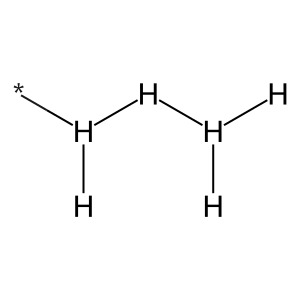

In [31]:
compound_index = 10

# Retrieve compound and its features from dataset
compound = tox21_datasets[0].X[compound_index]
atom_features = compound.get_atom_features()
adjacency = compound.get_adjacency_list()

# Create an RDKit molecule object
mol = Chem.RWMol()

# Add atoms to the molecule
for atom_feat in atom_features:
    atomic_number = int(atom_feat[0])
    atom = Chem.Atom(atomic_number)
    mol.AddAtom(atom)

# Add bonds to the molecule
bond_indices = set()
for i, neighbors in enumerate(adjacency):
    for j in neighbors:
        if (j, i) not in bond_indices:  # Check if bond already exists
            mol.AddBond(i, j, Chem.BondType.SINGLE)
            bond_indices.add((i, j))


# Convert the molecule to a non-editable RDKit molecule object
molecule = mol.GetMol()


# Generate a 2D depiction of the molecule
img = Chem.Draw.MolToImage(molecule)

# Show the molecule image
img.show()

## Training GCN Model

In [32]:
# Define metric for the model
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [33]:
# Define and fit the model
model = GraphConvModel(len(tox21_tasks), batch_size=32, mode='classification')
history = model.fit(train_dataset, nb_epoch=10)
print(history)

0.6741940180460612


### Evaluating the Model

In [36]:
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

print("Train scores\t", train_scores)
print("Validation scores\t", valid_scores)

Train scores	 {'roc_auc_score': 0.8996523314699526}
Validation scores	 {'roc_auc_score': 0.7242552993550442}


## Training GAT Model

In [37]:
# Define metric for the model
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [38]:
model = GraphConvModel(len(tox21_tasks), 
                 batch_size=32, 
                 mode='classification',
                 dropout=0.2,
                 activation_fn=tf.nn.relu,
                 model_dir = 'gat_model')

In [39]:
history = model.fit(train_dataset, nb_epoch=20)
print(history)

0.7457509517669678


### Evaluating the Model

In [40]:
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

print("Train scores\t", train_scores)
print("Validation scores\t", valid_scores)

Train scores	 {'roc_auc_score': 0.8805859920068954}
Validation scores	 {'roc_auc_score': 0.726741248777246}


## Training GGCN Model

In [41]:
# Define metric for the model
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [42]:
model = GraphConvModel(
    len(tox21_tasks),
    batch_size=32,
    mode = "classification",
    dropout = 0.2,
    activation_fn=tf.nn.relu,
    model_dir='ggcn_model'
)

In [43]:
history = model.fit(train_dataset, nb_epoch=20)
print(history)

0.7560021877288818


### Evaluating the Model

In [44]:
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

print("Train scores\t", train_scores)
print("Validation scores\t", valid_scores)

Train scores	 {'roc_auc_score': 0.8807082623157646}
Validation scores	 {'roc_auc_score': 0.749729995717737}


## Predicting Properties of a given molecule

In [45]:
compound_index = 10

compound = tox21_datasets[0].X[compound_index]
compound_batch = np.expand_dims(compound, axis=0)
predictions = model.predict_on_batch(compound_batch)
compound_predictions = predictions[0]

In [46]:
for task_name, predicted_value in zip(tox21_tasks, compound_predictions):
    print(f"{task_name}: {predicted_value}")

NR-AR: [0.8977039  0.10229603]
NR-AR-LBD: [0.9517217  0.04827822]
NR-AhR: [0.9818262  0.01817366]
NR-Aromatase: [0.9975301 0.0024698]
NR-ER: [0.69935274 0.30064726]
NR-ER-LBD: [0.934951  0.0650491]
NR-PPAR-gamma: [0.99299735 0.00700263]
SR-ARE: [0.9728916  0.02710834]
SR-ATAD5: [0.99404377 0.00595622]
SR-HSE: [0.9805376  0.01946235]
SR-MMP: [0.998755   0.00124501]
SR-p53: [0.9947747  0.00522524]


In [47]:
# Print out properties that molecule tested positive for
# ie. properties where prediction above threshold

taskval = 0
threshold = 0.1

for val in compound_predictions:
  if(val[1]>threshold):
    print(tox21_tasks[taskval])
  taskval = taskval + 1

NR-AR
NR-ER


In the context of the 'NR-AR' task, a predicted value of 1 indicates that the compound is predicted to be active in binding to the androgen receptor. This means that the compound has a higher likelihood of interacting with the receptor and potentially affecting the related biological pathway. However, whether this activity is considered toxic or not depends on the specific application, desired effects, and the potential consequences of modulating the androgen receptor pathway.
